In [1]:
import sys
print(sys.version_info)
from io import BytesIO

import math
from sqlalchemy import create_engine
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)


In [2]:
localhost = {'user': 'postgres', 'password': 'postgres', 'host': 'localhost', 'port': 5432, 'db': 'fiadb'}
params = 'postgresql://{0}:{1}@{2}:{3}/{4}'
engine = create_engine(params.format(localhost['user'], localhost['password'], localhost['host'], localhost['port'], localhost['db']))
# geom_sql = """select distinct grid_id, grid_geom from fs_fiadb.pergrid"""
predictor_all = """select distinct * from predictor.pergrid_base"""
predictor_all_df = pd.read_sql(predictor_all, engine)
predictor_all_df.columns

Index(['grid_id', 'aet', 'ai', 'art', 'ewd', 'fa', 'map', 'mat', 'mpdq',
       'mtcq', 'pet', 'psn', 'ra', 'rmap', 'rmat', 'tsn', 'mfdf', 'alt', 'shg',
       'mtwq', 'wkb_geometry', 'tsr', 'wa'],
      dtype='object')

In [3]:
predictor_all_df.shg = predictor_all_df.shg.replace({None: ""})

In [4]:
predictor_all_df.head()

,grid_id,aet,ai,art,ewd,fa,map,mat,mpdq,mtcq,...,rmap,rmat,tsn,mfdf,alt,shg,mtwq,wkb_geometry,tsr,wa
0,110,6000.0,0.3675,21.191667,-2.523666e+06,7.7058,681.0,20.036236,87.0,16.299375,...,2.833333,0.604166,444.860212,2.27,11.597701,,28.792500,0103000020AD1000000100000005000000284215D19A6E...,4.0,4.1166
1,111,65535.0,0.3829,20.233612,-2.537902e+06,14.1498,699.0,20.298634,92.0,16.340292,...,2.000000,0.620833,444.259982,2.10,5.982890,5,28.717458,0103000020AD100000010000000500000019FF84D9F561...,2.0,11.8152
2,195,65535.0,NaN,0.164286,-5.247088e+02,0.0711,1148.5,0.309987,131.5,21.304167,...,1.833333,0.241667,3.698817,NaN,0.011696,,28.626191,0103000020AD1000000100000005000000CD9FCA607C43...,5.0,302.9049
3,337,5135.0,0.2898,23.950167,-2.941595e+06,3.0042,565.0,20.193576,76.0,15.517042,...,2.333333,0.391667,492.281141,2.12,61.886973,,29.458834,0103000020AD1000000100000005000000909FA3E581A1...,1.0,1.2528
4,338,5645.0,0.3017,23.526261,-2.959517e+06,10.0350,580.0,20.710174,80.0,15.754000,...,3.416667,0.620833,489.587254,2.12,32.270955,5,29.300416,0103000020AD100000010000000500000099D4584CD794...,1.0,4.2480


In [5]:
categorical_columns = ['shg']
numerical_columns = ['aet', 'ai', 'art', 'ewd', 'fa', 'map', 'mat', 'mpdq',
       'mtcq', 'pet', 'psn', 'ra', 'rmap', 'rmat', 'tsn', 'mfdf', 'alt',
       'mtwq', 'wa']

In [6]:
X = predictor_all_df[categorical_columns + numerical_columns]
y = predictor_all_df['tsr']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [9]:
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

In [10]:
preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

In [11]:
rf_classifer = RandomForestRegressor(n_estimators = 10, random_state = 42, 
                                         min_samples_leaf=10, 
                                         bootstrap=True)
rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', rf_classifer)
])
rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [12]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 0.940
RF test accuracy: 0.895


In [13]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=0)
perm_sorted_idx = result.importances_mean.argsort()

In [14]:
perm_importance = pd.DataFrame(
    {'feature': X_train.columns[perm_sorted_idx],
    'perm_importance': result.importances_mean[perm_sorted_idx].T})

In [16]:
perm_importance.sort_values('perm_importance', ascending=False).head()

,feature,perm_importance
19,ai,0.499357
18,fa,0.380762
17,mpdq,0.125581
16,ewd,0.031769
15,map,0.022832


In [167]:
from scipy.stats import spearmanr 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [172]:
# encode categorical variable
var= ['aet', 'ai', 'art', 'ewd', 'fa', 'map', 'mat', 'mpdq',
       'mtcq', 'pet', 'psn', 'ra', 'rmap', 'rmat', 'tsn', 'mfdf', 'alt','mtwq','wa','tsr']
pergrid_base_df = predictor_all_df[var]

In [173]:
# enc = OneHotEncoder(handle_unknown='ignore')
# enc_df = pd.DataFrame(enc.fit_transform(predictor_all_df[['shg']]).toarray())
# new_var = var + ['shg0', 'shg1', 'shg2', 'shg3', 'shg4', 'shg5', 'shg6']
# pergrid_base_df = pergrid_base_df.join(enc_df)

le = LabelEncoder()
le_df = pd.DataFrame(le.fit_transform(predictor_all_df[['shg']]))
pergrid_base_df = pergrid_base_df.join(le_df)
new_var = var + ['shg']

In [174]:
pergrid_base_df.head()

,aet,ai,art,ewd,fa,map,mat,mpdq,mtcq,pet,...,ra,rmap,rmat,tsn,mfdf,alt,mtwq,wa,tsr,0
0,6000.0,0.3675,21.191667,-2.523666e+06,7.7058,681.0,20.036236,87.0,16.299375,1826.768199,...,16.0,2.833333,0.604166,444.860212,2.27,11.597701,28.792500,4.1166,4.0,0
1,65535.0,0.3829,20.233612,-2.537902e+06,14.1498,699.0,20.298634,92.0,16.340292,1811.927757,...,14.0,2.000000,0.620833,444.259982,2.10,5.982890,28.717458,11.8152,2.0,5
2,65535.0,NaN,0.164286,-5.247088e+02,0.0711,1148.5,0.309987,131.5,21.304167,1918.111111,...,1.0,1.833333,0.241667,3.698817,NaN,0.011696,28.626191,302.9049,5.0,0
3,5135.0,0.2898,23.950167,-2.941595e+06,3.0042,565.0,20.193576,76.0,15.517042,1972.128352,...,108.0,2.333333,0.391667,492.281141,2.12,61.886973,29.458834,1.2528,1.0,0
4,5645.0,0.3017,23.526261,-2.959517e+06,10.0350,580.0,20.710174,80.0,15.754000,1928.968811,...,34.0,3.416667,0.620833,489.587254,2.12,32.270955,29.300416,4.2480,1.0,5


In [175]:
# fill NaN with values from neighbor pixels
imputer = KNNImputer(n_neighbors=5)
pergrid_base_filled = imputer.fit_transform(pergrid_base_df)
pergrid_base_df = pd.DataFrame(pergrid_base_filled)
pergrid_base_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,6000.0,0.36750,21.191667,-2.523666e+06,7.7058,681.0,20.036236,87.0,16.299375,1826.768199,...,16.0,2.833333,0.604166,444.860212,2.270,11.597701,28.792500,4.1166,4.0,0.0
1,65535.0,0.38290,20.233612,-2.537902e+06,14.1498,699.0,20.298634,92.0,16.340292,1811.927757,...,14.0,2.000000,0.620833,444.259982,2.100,5.982890,28.717458,11.8152,2.0,5.0
2,65535.0,1.30362,0.164286,-5.247088e+02,0.0711,1148.5,0.309987,131.5,21.304167,1918.111111,...,1.0,1.833333,0.241667,3.698817,6.524,0.011696,28.626191,302.9049,5.0,0.0
3,5135.0,0.28980,23.950167,-2.941595e+06,3.0042,565.0,20.193576,76.0,15.517042,1972.128352,...,108.0,2.333333,0.391667,492.281141,2.120,61.886973,29.458834,1.2528,1.0,0.0
4,5645.0,0.30170,23.526261,-2.959517e+06,10.0350,580.0,20.710174,80.0,15.754000,1928.968811,...,34.0,3.416667,0.620833,489.587254,2.120,32.270955,29.300416,4.2480,1.0,5.0


In [176]:
# calcualte spearman correlation coefficient
corr = spearmanr(pergrid_base_df).correlation

In [177]:
corr_sort_abs = pd.DataFrame(corr, columns=new_var)['tsr'].abs()

In [178]:
corr_sort_abs_df = pd.DataFrame(
    {'feature': new_var,
    'correlation': corr_sort_abs.tolist()})
# corr_sort_abs_df.drop(corr_sort_abs_df.tail(1).index,inplace=True)

In [179]:
corr_sort_abs_df.drop([19],inplace=True)

In [180]:
corr_sort_abs_df.sort_values('correlation', ascending=False)

,feature,correlation
7,mpdq,0.784993
1,ai,0.759374
5,map,0.758417
0,aet,0.716168
4,fa,0.651447
16,alt,0.540455
10,psn,0.534306
9,pet,0.407523
18,wa,0.391917
15,mfdf,0.342735


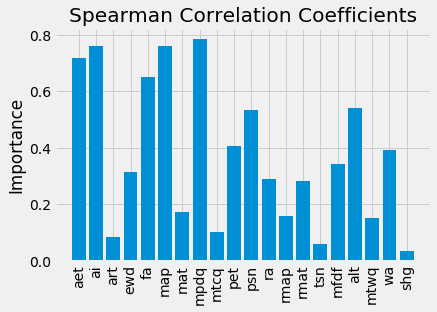

In [181]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
plt.rc('font', size=12)          # controls default text sizes
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(corr_sort_abs_df.shape[0]))
# Make a bar chart
plt.bar(x_values, corr_sort_abs_df['correlation'], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, corr_sort_abs_df['feature'], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); 
# plt.xlabel('Variable'); 
plt.title('Spearman Correlation Coefficients');

In [99]:
corr_sort_abs_df.shape[0]

26